# EAS 4610
## Final Group Project
## Glacial Cycles (Pollard 1982)

### Dennis Frank
### Marcus Morris
### Nathan Warner

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
import pandas as pd

# Introduction

# Equations

In [2]:
#Constants
a=0.81e-3 #Snowfall Constant, Unit:(1/yr) 
b=0.3e-6 #Ice Melt Constant, Unit:(1/(m*yr))
k_sens=25 #Insolation Sensitivity (m*day/Ly)
k_sens = k_sens / 41840 # 1 Ly = 41840 J/m^2
S=0 #Elevation of Current Sea Level
pi=917 #ice density (kg/m^3)
pw=1027 #sea water density (kg/m^3)
A = 5.77e-4 # 1/(m^3 yr)
alpha = 5
beta = 2
r = 0.3
nu = 100 # km^2/yr
nu = nu * 1000 * 1000

t_f = 10000
x_f = 4884000
dt = 0.1 #yr
dx = 55500 #m
nt = int(t_f/dt) + 1
nx = int(x_f/dx) + 1
x = np.linspace(0, x_f, nx)
t = np.linspace(0, t_f, nt)

c_nu = (nu * dt) / (dx**2)
c_A = (A * dt) / (4*dx**2)

In [3]:
#Function for Calculating the Mass Balance, G: (Snowfall - Ice Melt)
def G(h,h_prime,h_prev,h_prime_prev,E0,dQ): #h:ice height, h':bedrock elevation, x:distance, E0:current equilibrium altitude, dq:insolation change @ 65°N
    E = E0 + k_sens*dQ
    H = h+h_prime #Surface Elevation: H=h+h'
#    if (pi*h_prev < (pw*(S-h_prime_prev))) and (h_prime < S): #Calving Conditional Statement (maybe put this in separte fxn)
#        return -20
#     if (H-E) <= -1000:
#         return a*(H-E) - b*((H-E)**2)
#     else:
    return 0.56

In [9]:
h = np.zeros([nx, nt])
h_prime = np.zeros([nx, nt])

## Initial conditions
h_0 = np.zeros([nx])
h_prime_0 = np.zeros([nx])
h_naught = np.zeros([nx])

h[:, 0] = h_0
h_prime[:, 0] = h_prime_0

## EQUATION 3 MATRICES
h_prime_data = np.array([c_nu*np.ones(nx), (1-2*c_nu)*np.ones(nx), c_nu*np.ones(nx)])
h_prime_diags = np.array([-1, 0, 1])
h_prime_M_3 = spdiags(h_prime_data, h_prime_diags, nx, nx).toarray()

h_0_data = np.array([-c_nu*np.ones(nx), (2*c_nu)*np.ones(nx), -c_nu*np.ones(nx)])
h_0_diags = np.array([-1, 0, 1])
h_0_M_3 = spdiags(h_0_data, h_0_diags, nx, nx).toarray()

h_data = np.array([r*c_nu*np.ones(nx), (-2*r*c_nu)*np.ones(nx), r*c_nu*np.ones(nx)])
h_diags = np.array([-1, 0, 1])
h_M_3 = spdiags(h_data, h_diags, nx, nx).toarray()

## EQUATION 3 BOUNDARY CONDITIONS
h_prime_M_3[0, 0] = 0
h_prime_M_3[0, 1] = 0
h_prime_M_3[-1, -1] = 0
h_prime_M_3[-1, -2] = 0

h_0_M_3[0, 0] = 1
h_0_M_3[0, 1] = 0
h_0_M_3[-1, -1] = 1
h_0_M_3[-1, -2] = 0

h_M_3[0, 0] = 0
h_M_3[0, 1] = 0
h_M_3[-1, -1] = 0
h_M_3[-1, -2] = 0

#Define Insolation as a Function of Time (Q)
df = pd.read_csv('Milankovitch.dat',skiprows=1300,delim_whitespace=True, names=['year','lat','Q','x','y','z','v']) #only first 3 rows are of interest
Q = df['Q'].to_numpy() #values in W/m^2
n = np.ceil(len(t)/len(Q))
Q = list(np.repeat(Q,n)) #repeat values
#Run Loop to calculate dQ
Q_present=Q[-1]
dQ = np.ones((len(Q),1))
for i in np.arange(len(Q)):
    dQ[i] = Q[i] - Q_present
dQ = dQ.reshape(-1)
dQ = dQ * 60 * 60 * 24 # convert to J/(m^2 * day)
#Define Equilibrium-Line Altitude as a Function of latitude
E0 = (0.9e-3)*x - 99.9

## MASTER LOOP
time = 10000
for k in np.arange(0, time):
    # EQUATION 1 MATRICES
    K = np.zeros([nx])
    K[1:-1] = h[1:-1,k]**alpha + abs(((h[2:nx,k] - h[0:nx-2,k])/(2*dx)) + ((h_prime[2:nx,k] - h_prime[0:nx-2,k])/(2*dx)))**beta
#     K[0] = K[1]
#     K[-1] = K[nx - 2]

    h_1 = np.zeros(nx)
    h_1[0:nx-2] = c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] - c_A*K[2:nx]
    h_2 = np.zeros(nx)
    h_2[1:nx-1] = 1 - 8*c_A*K[1:nx-1]
    h_2[0] = 1
    h_2[-1] = 1
    h_3 = np.zeros(nx)
    h_3[2:nx] = -c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] + c_A*K[2:nx]
    h_diags = np.array([-1, 0, 1])
    h_M = spdiags(np.array([h_1, h_2, h_3]), h_diags, nx, nx).toarray()

    h_p_1 = np.zeros(nx)
    h_p_1[0:nx-2] = c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] - c_A*K[2:nx]
    h_p_2 = np.zeros(nx)
    h_p_2[1:nx-1] = -8*c_A*K[1:nx-1]
    h_p_3 = np.zeros(nx)
    h_p_3[2:nx] = -c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] + c_A*K[2:nx]
    h_p_diags = np.array([-1, 0, 1])
    h_p_M = spdiags(np.array([h_p_1, h_p_2, h_p_3]), h_diags, nx, nx).toarray()
    
    # Find G
    G_M = np.zeros(nx)
    this_dQ = dQ[k]
    G_M[0] = G(h[0, k], h_prime[0, k], h[0, k], h_prime[0, k], E0[0], this_dQ)
    
    for i in np.arange(1, nx-1):
        G_M[i] = G(h[i, k], h_prime[i, k], h[i-1, k], h_prime[i-1, k], E0[i], this_dQ)
        
    # Find h at next time step
    h_new = h_M@h[:,k] + h_p_M@h_prime[:,k] + G_M*dt
    h[:, k+1] = h_new.transpose()
    
    # Find h_prime at next time step    
    h_prime_new = h_prime_M_3@h_prime[:,k] + h_0_M_3@h_naught[:] + h_M_3@h[:,k]
    h_prime[:, k+1] = h_prime_new.transpose()
    
h[:,time]


array([560.        , 496.19720456, 511.34709491, 469.67899643,
       488.76671646, 473.744527  , 483.75287471, 477.79449471,
       483.21608222, 480.19251243, 483.7359891 , 481.63303558,
       484.47122062, 482.47593338, 485.15662676, 482.90088909,
       485.69810772, 483.03729255, 486.07199353, 482.99864847,
       486.29350785, 482.87858065, 486.39907964, 482.74179837,
       486.4309448 , 482.62365644, 486.42615043, 482.53812872,
       486.41205778, 482.48865294, 486.40662902, 482.47736011,
       486.41986951, 482.51070682, 486.45323834, 482.6006229 ,
       486.49541134, 482.75983221, 486.5151466 , 482.98948236,
       486.45561834, 483.25952396, 486.23824332, 483.49007051,
       485.78177571, 483.55099826, 485.02839481, 483.29205399,
       483.95378612, 482.58954121, 482.54891457, 481.37527945,
       480.79254981, 479.62953465, 478.64143517, 477.35229137,
       476.03945465, 474.53747104, 472.92860661, 471.16123869,
       469.25140348, 467.1810279 , 464.94688099, 462.53

In [43]:
hsum = []

for item in h:
    hsum.append(np.sum(item))

hsumnew[0] = 0

for i in range(len(hsum)-1):
    hsumnew.append((hsum[i] + hsum[i+1]) * (dx/2)) 
    
hsumnew

[0,
 154649028401.80215,
 153529087143.80072,
 152965716509.31238,
 152659224516.97296,
 152523510252.41815,
 152471539042.68475,
 152456999742.42538,
 152458470050.31577,
 152466528963.8935,
 152476629618.41864,
 152486555945.47,
 152495083116.22733,
 152501566931.84012,
 152505662972.2772,
 152507227694.78488,
 152506257743.19003,
 152502827588.09357,
 152497085179.3748,
 152489189972.58374,
 152479326016.59116,
 152467647400.1651,
 152454299154.4507,
 152439378946.83035,
 152422960582.08072,
 152405072111.3186,
 152385716434.74496,
 152364860037.79727,
 152342446660.24152,
 152318390084.77487,
 152292579357.45258,
 152264871256.6903,
 152235087799.00098,
 152203007574.66162,
 152168357983.35245,
 152130808489.51804,
 152089960345.211,
 152045347416.6205,
 151996424281.20428,
 151942581594.97137,
 151883131558.07672,
 151817345928.511,
 151744436750.3774,
 151663621019.75946,
 151574089724.52493,
 151475088933.4786,
 151365865352.70166,
 151245741889.4192,
 151114037460.7968,
 150970

In [5]:
h[:,1800]

array([100.8       , 100.8       , 100.8       , 100.8       ,
       100.8       , 100.8       , 100.8       , 100.8       ,
       100.8       , 100.8       , 100.8       , 100.8       ,
       100.8       , 100.8       , 100.8       , 100.8       ,
       100.8       , 100.8       , 100.8       , 100.8       ,
       100.8       , 100.8       , 100.8       , 100.8       ,
       100.8       , 100.8       , 100.8       , 100.8       ,
       100.8       , 100.8       , 100.8       , 100.8       ,
       100.8       , 100.8       , 100.8       , 100.8       ,
       100.8       , 100.8       , 100.8       , 100.8       ,
       100.8       , 100.8       , 100.8       , 100.8       ,
       100.8       , 100.8       , 100.8       , 100.8       ,
       100.8       , 100.8       , 100.8       , 100.8       ,
       100.8       , 100.8       , 100.8       , 100.8       ,
       100.8       , 100.8       , 100.8       , 100.8       ,
       100.8       , 100.8       , 100.8       , 100.8 

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


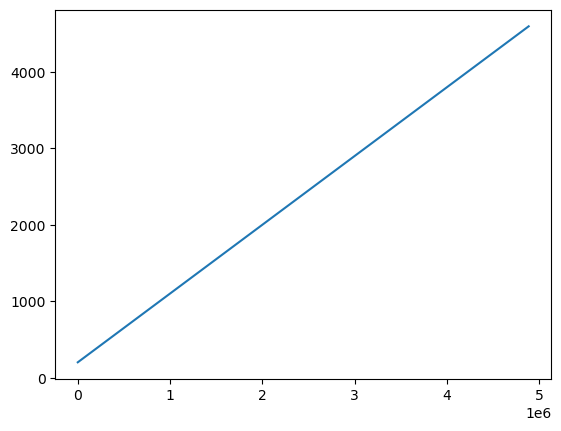

In [6]:
E0 = (0.9e-3)*x - 99.9
E = E0 + k_sens*dQ[0]
plt.plot(x,E)
k_sens
dQ[0]
E0

for i in np.arange(1, 20):
    print(i)

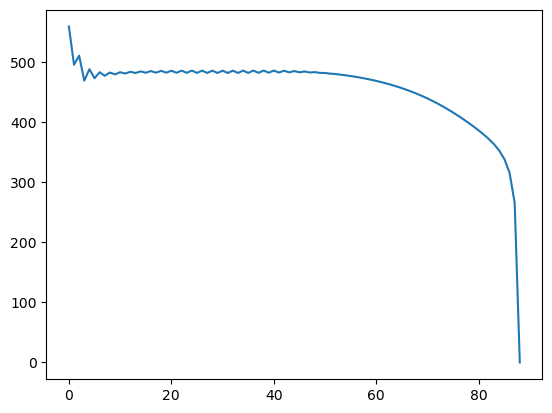

In [7]:
plt.plot(h[:,time])
plt.show()

# Numerical Methods

# Results

# Figures

# Video Walkthrough

# References